# Extrapolation and Neural Networs

Let's look at the extrapolation problem that random forests have.

### The Extrapolation Problem

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from fastai.tabular.all import (
    add_datepart,
    cont_cat_split,
    tabular_learner,
    Categorify,
    F,
    FillMissing,
    Normalize,
    TabularPandas,
)
from fastbook import (
    Path,
    load_pickle,
)
from sklearn.ensemble import RandomForestRegressor

from evaluation import m_rmse, r_mse

np.random.seed(42)

Let's consider the simple task of making predictions from 40 data points showing a slightly noisy linear relationship

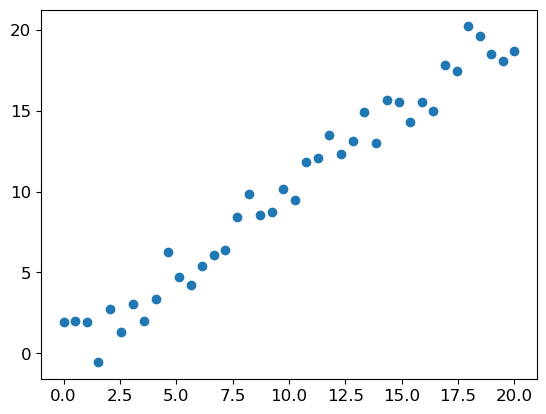

In [2]:
x_lin = torch.linspace(start=0, end=20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)

plt.scatter(x_lin, y_lin)

Although we only have a single independent variable, sklearn expects a matrix of independent variables, not a single vector. So we have to turn our vector into a matrix with one column. In other words, we have to change the shape from `[40]` to `[40, 1]`.

In [3]:
xs_lin = x_lin.unsqueeze(1)
x_lin.shape, xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

In [4]:
# A more flexible approach is to slice an array or tensor with the special value None, which introduces an additional unit axis at that location:

x_lin[:, None].shape

torch.Size([40, 1])

In [5]:
# We can now create a random forest for this data
m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])

Then we'll test the model on the full dataset. The blue dots are the training data, and the red dots are the predictions:

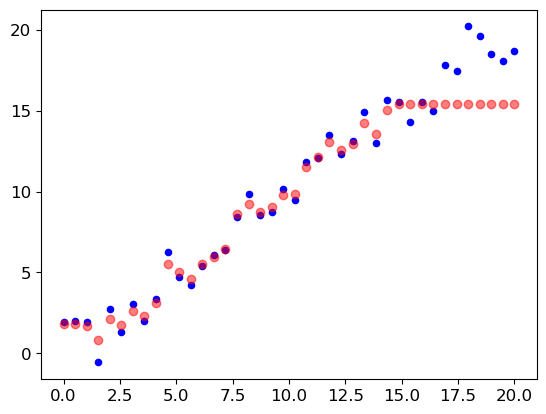

In [6]:
plt.scatter(x_lin, y_lin, 20, color="blue")
plt.scatter(x_lin, m_lin.predict(xs_lin), color="red", alpha=0.5)

We have a problem! Our predictions outside of the domain that our training data covered are all too low.

Remember, a random forest just averages the predictions of a number of trees. And a tree simply predicts the average value of the rows in a leaf. Therefore, a tree and a random forest can never predict values outside of the range of the training data. This is particularly problematic for data where there is a trend over time, such as inflation, and you wish to make predictions for a future time.


But the problem extends beyond time variables. Random forests are not able to extrapolate outside of the types of data they have seen, in a more general sense. That's why we need to make sure our validation set does not contain out-of-domain data.

### Finding Out-of-Domain Data

Sometimes it is hard to know whether your test set is distributed in the same way as your training data, or, if it is different, what columns reflect that difference. We can figure out this using a Random Forest.

In this case we don't use the random forest to predict our actual dependent variable. Instead, we try to predict whether a row is in the validation set or the training set.

To see this in action, let's combine our training and validation sets together, create a dependent variable that represents which dataset each row comes from, build a random forest using that data, and get its feature importance:

In [7]:
# loading data
path = Path('/home/david/.fastai/archive/bluebook-for-bulldozers')
Path.BASE_PATH = path

to = load_pickle(path / "to.pkl")

xs_final = load_pickle(path / "xs_final.pkl")
y = to.train.y
valid_xs_final = load_pickle(path / "valid_xs_final.pkl")
valid_y = to.valid.y

In [8]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

In [9]:
def random_forest(
    xs: pd.DataFrame,
    y: pd.Series,
    n_estimators: int = 40,
    max_samples: int = 200_000,
    max_features: float = 0.5,
    min_samples_leaf: int = 5,
    **kwargs
):
    return RandomForestRegressor(
        n_jobs=-1,
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        oob_score=True
    ).fit(xs, y)

In [10]:
def rf_feat_importance(model, df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame(
        {'cols': df.columns, 'importance': model.feature_importances_}
    ).sort_values('importance', ascending=False)

In [11]:
model = random_forest(df_dom, is_valid)

rf_feat_importance(model, df_dom)[:6]

,cols,importance
9,SalesID,0.393375
12,saleYear,0.308333
13,MachineID,0.122186
0,YearMade,0.038310
4,ModelID,0.035318
11,fiBaseModel,0.026689


This shows that there are 3 columns that differ significantly between the training and validation sets: `saleYear`, `SalesID`, and `MachineID`.

It's fairly obvious why this is the case for `saleYear`: it's the number of days between the start of the dataset and each row, so it directly encodes the date. The difference in `SalesID` suggests that identifiers for auction sales might increment over time. `MachineID` suggests something similar might be happening for individual items sold in those auctions.

Let's get a baseline of the original random forest model's RMSE, then see what the effect is of removing each of these columns in turn:



In [14]:
model = random_forest(xs_final, y)
print("original", m_rmse(model, valid_xs_final, valid_y))

for c in ("SalesID", "saleYear", "MachineID"):
    m = random_forest(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

original 0.231013
SalesID 0.230738
saleYear 0.235453
MachineID 0.230628


In [17]:
# It looks like we should be able to remove SalesID and MachineID without losing any accuracy. Let's check:

time_vars = ["SalesID", "MachineID"]
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = random_forest(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.229122

Removing these variables has slightly improved the model's accuracy; but more importantly, it should make it more resilient over time, and easier to maintain and understand.


------


One thing that might help in our case is to simply avoid using old data. Often, old data shows relationships that just aren't valid any more. Let's try just using the most recent few years of the data:

<AxesSubplot:>

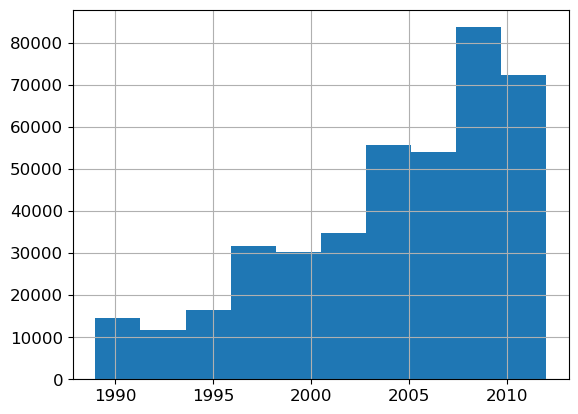

In [15]:
xs_final["saleYear"].hist()

In [18]:
filt = xs_final["saleYear"] > 2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [19]:
model = random_forest(xs_filt, y_filt)
m_rmse(model, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.19293, 0.229122)

It's a tiny bit better, which shows that you shouldn't always just use your entire dataset; sometimes a subset can be better.



### Using a Neural Network

Let's first replicate the steps we took to set up the TabularPandas object

In [25]:
df_nn = pd.read_csv(path / "TrainAndValid.csv", low_memory=False)

df_nn["ProductSize"] = df_nn["ProductSize"].astype("category")

sizes = "Large", "Large / Medium", "Medium", "Small", "Mini", "Compact"
df_nn["ProductSize"].cat.set_categories(sizes, ordered=True, inplace=True)

/home/david/anaconda3/envs/fast.ai/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [27]:
dep_var = "SalePrice"

df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, "saledate")

In [28]:
df_nn.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2006,11,46,16,3,320,False,False,False,False,False,False,1.163635e+09
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2004,3,13,26,4,86,False,False,False,False,False,False,1.080259e+09
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004,2,9,26,3,57,False,False,False,False,False,False,1.077754e+09
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metric Tons",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,5,20,19,3,139,False,False,False,False,False,False,1.305763e+09
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,7,30,23,3,204,False,False,False,False,False,False,1.248307e+09


In [30]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]
df_nn_final.columns

Index(['YearMade', 'ProductSize', 'Coupler_System', 'fiProductClassDesc',
       'ModelID', 'fiSecondaryDesc', 'Hydraulics_Flow', 'ProductGroup',
       'Enclosure', 'fiModelDescriptor', 'fiBaseModel', 'saleYear',
       'Hydraulics', 'Drive_System', 'Tire_Size', 'Pad_Type', 'SalePrice'],
      dtype='object')

Categorical columns are handled very differently in neural networks, compared to decision tree approaches. In a neural net a great way to handle categorical variables is by using embeddings.


To create embeddings, fastai needs to determine which columns should be treated as categorical variables. It does this by comparing the number of distinct levels in the variable to the value of the `max_card` parameter. If it's lower, fastai will treat the variable as categorical.

In [32]:
cont_nn, cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)


In [35]:
cont_nn, cat_nn

([],
 ['YearMade',
  'ProductSize',
  'Coupler_System',
  'fiProductClassDesc',
  'ModelID',
  'fiSecondaryDesc',
  'Hydraulics_Flow',
  'ProductGroup',
  'Enclosure',
  'fiModelDescriptor',
  'fiBaseModel',
  'saleYear',
  'Hydraulics',
  'Drive_System',
  'Tire_Size',
  'Pad_Type'])

In [36]:
# Let's take a look at the cardinality of each of the categorical variables that we have chosen so far:

df_nn_final[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
Hydraulics_Flow          3
ProductGroup             6
Enclosure                6
fiModelDescriptor      140
fiBaseModel           1961
saleYear                24
Hydraulics              12
Drive_System             4
Tire_Size               17
Pad_Type                 4
dtype: int64

In [41]:
df = pd.read_csv(path / "TrainAndValid.csv", low_memory=False)

df = add_datepart(df, "saledate")

condition = (df.saleYear < 2011) | (df.saleMonth < 10)
# np.where is a useful function that returns (as the first element of a tuple) the indices of all True values
train_idx = np.where(condition)[0]
valid_idx = np.where(~condition)[0]

splits = (list(train_idx), list(valid_idx))

We can create our `TabularPandas` object in the same way as when we created our random forest, with one very important addition: `normalization`. 

In [42]:
procs_nn = [Categorify, FillMissing, Normalize]

to_nn = TabularPandas(
    df_nn_final,
    procs_nn,
    cat_nn,
    cont_nn,
    splits=splits,
    y_names=dep_var
)

/home/david/anaconda3/envs/fast.ai/lib/python3.9/site-packages/fastai/tabular/core.py:279: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  to.conts = (to.conts-self.means) / self.stds


In [43]:
batch_size = 1024
dls = to_nn.dataloaders(batch_size)

In [44]:
# As we've discussed, it's a good idea to set y_range for regression models, so let's find the min and max of our dependent variable:

y = to_nn.train.y
y.min(), y.max()

(8.465899, 11.863583)

We can now create the Learner to create this tabular model.

By default, for tabular data fastai creates a neural network with two hidden layers, with 200 and 100 activations, respectively. This works quite well for small datasets, but here we've got quite a large dataset, so we increase the layer sizes.

In [49]:
learner = tabular_learner(
    dls,
    y_range=(8,12),
    layers=[500,250],
    n_out=1,
    loss_func=F.mse_loss
)

SuggestedLRs(valley=0.0002290867705596611)

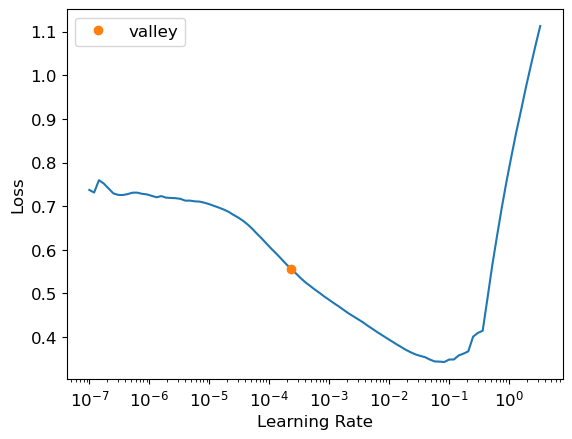

In [50]:
# find learning rate
learner.lr_find()

In [53]:
epochs = 5
lr = 1e-2
learner.fit_one_cycle(epochs, lr)

In [55]:
# We can use our r_mse function to compare the result to the random forest result we got earlier:

preds, targs = learner.get_preds()
r_mse(preds, targs)

0.221598

It's quite a bit better than the random forest (although it took longer to train, and it's fussier about hyperparameter tuning).

In [56]:
learner.save("nn")

Path('models/nn.pth')